In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
import HDF5

In [2]:
include("../model-41-sym/likelihood.jl")
include("../model-41-sym/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [4]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [5]:
β1 = 0.015
β2 = 0.0077 # (0.8/30/sqrt(12))
β3 = 0.0058 # (0.8/40/sqrt(12))

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), ],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), ],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), ],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), ],
        mixt_pow =  0.35 .. 1.0, 
        waist = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        waist_2 = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.47799, 15.025999, 23.1644],
);

labels = [ 
    L"\sigma_{h,x}", 
    L"\sigma_{h,y}",
    L"\sigma_{c,x}", 
    L"\sigma_{c,y}",
    L"\sigma'_{h,x}", 
    L"\sigma'_{h,y}",
    L"\sigma'_{c,x}", 
    L"\sigma'_{c,y}",  
    L"\alpha",
    L"s_{w,h}",
    L"s_{w,c}",
    L"\mu_{1,x}", 
    L"\mu_{2,x}",
    L"\mu_{3,x}", 
    L"\mu_{4,x}",
    L"\mu_{1,y}", 
    L"\mu_{2,y}",
    L"\mu_{3,y}", 
    L"\mu_{4,y}",
    L"p_4", 
    L"f_4", 
    L"i_4", 
    L"\tilde{\sigma}_{4,x}", 
    L"\tilde{\sigma}_{4,y}",
    L"i_1", 
    L"i_2", 
    L"i_3"
];

In [6]:
FPATH = "../../data/sampling_results/Benchmark-15/"

"../../data/sampling_results/Benchmark-15/"

In [7]:
readdir(FPATH)

48-element Vector{String}:
 "hc-1.hdf5"
 "hc-11.hdf5"
 "hc-113.hdf5"
 "hc-13.hdf5"
 "hc-167.hdf5"
 "hc-171.hdf5"
 "hc-173.hdf5"
 "hc-179.hdf5"
 "hc-181.hdf5"
 "hc-183.hdf5"
 "hc-187.hdf5"
 "hc-191.hdf5"
 "hc-203.hdf5"
 ⋮
 "hc-395.hdf5"
 "hc-423.hdf5"
 "hc-433.hdf5"
 "hc-437.hdf5"
 "hc-439.hdf5"
 "hc-455.hdf5"
 "hc-49.hdf5"
 "hc-51.hdf5"
 "hc-63.hdf5"
 "hc-69.hdf5"
 "hc-73.hdf5"
 "hc-99.hdf5"

In [8]:
# Plots: "lc-52.hdf5"  "hc-90.hdf5"

fname = "hc-167.hdf5"  #readdir(FPATH)[8]
smpl_tmp = bat_read(FPATH*fname).result
samples = varshape(prior).(smpl_tmp);

In [9]:
fname

# Example HC "hc-2.hdf5"
# Example LC "lc-169.hdf5"

"hc-167.hdf5"

In [10]:
smpl_vect = mode(samples)[1]

(tr_size = [0.09880709249102107], tr_size_2 = [0.13055039522150477], ang_spr = [5.985382910041934], ang_spr_2 = [2.3766515462703417], mixt_pow = 0.7364059639828752, waist = [3.222811607434877], waist_2 = [2.7254918994457644], algmx = [33.019762467518575, 34.00261411721677, 21.586364956287127, 35.11626026103058], algmy = [36.41449915499581, 37.390624666889586, 20.314201439625503, 34.116211923949116], cam4_ped = 28.383540622797348, cam4_light_fluct = 1.9248855126239224, cam4_light_amp = 8.484061414693343, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.909140097044359, cam4_resy = 3.8837732310390454, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.17254509480908, 10.101472462729275, 2.667797616974954], s_cam = [0.0, 1.47799, 15.025999, 23.1644])

In [11]:
bat_eff_sample_size(samples).result

ShapedAsNT((tr_size = [4305.836536225658], tr_size_2 = [4152.699899387275], ang_spr = [2377.5279233101433], ang_spr_2 = [3080.97316433143], mixt_pow = 3076.342192919964, waist = [4086.2424600845666], waist_2 = [6111.943576003551], algmx = [3735.081339048537, 4736.896253324755, 3020.0157754122833, 3177.794091274989], algmy = [3562.060494274919, 4110.351841622102, 3033.907584266871, 2815.8996911031304], cam4_ped = 3035.472341021249, cam4_light_fluct = 3506.828505752585, cam4_light_amp = 2945.968160349625, resx = 3-element Fill{Int64}: entries equal to 563646, resy = 3-element Fill{Int64}: entries equal to 563646, cam4_resx = 3998.9069667130375, cam4_resy = 5144.435329352801, psx = 3-element Fill{Int64}: entries equal to 563646, psy = 3-element Fill{Int64}: entries equal to 563646, cam4_psx = 0-dimensional Fill{Int64}: entries equal to 563646, cam4_psy = 0-dimensional Fill{Int64}: entries equal to 563646, light_amp = [3693.2790470489826, 5521.2304087401635, 3385.2520780926397], s_cam = 4-

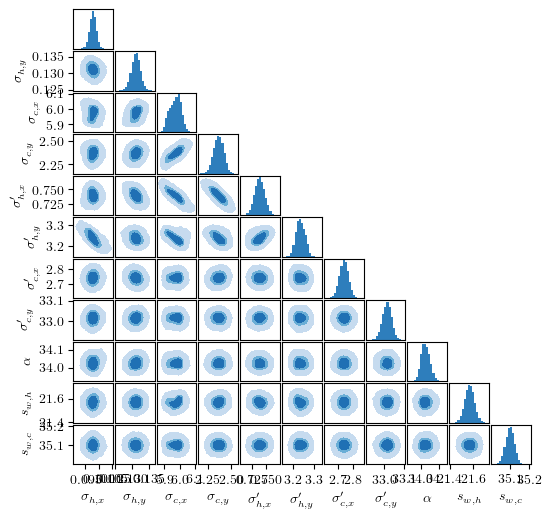

In [12]:
dims = [1,2,3,4,5,6,7,8,9,10, 11]
names = labels[dims]
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
# levels = [0.001, 0.65, 0.95, 1,]
figsize = (5.905631659056317, 5.905631659056317)  #(12,12)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

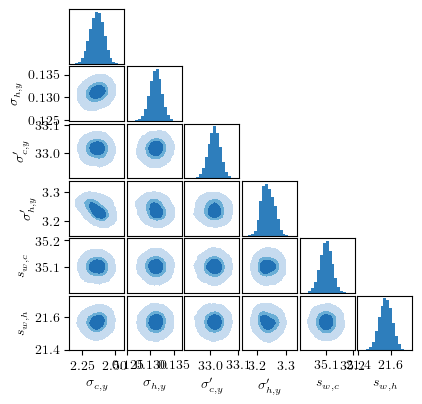

In [13]:
# dims = [3,1,7,5,11,10]
dims = [4,2,8,6,11,10]
names = labels[dims]
levels = [0.1, 0.65, 0.9, 0.95,  1,]
# levels = [0.001, 0.65, 0.95, 1,]
figsize = (4.429223744292238, 4.429223744292238) #(12,12)
n_bins = 20
filename = "../../plots/cont-m2.pdf"

corner_plots(samples, dims, names, levels_quantiles = levels, 
    figsize=figsize, 
    N_bins=n_bins, 
    saveplot = true, 
    filename=filename)

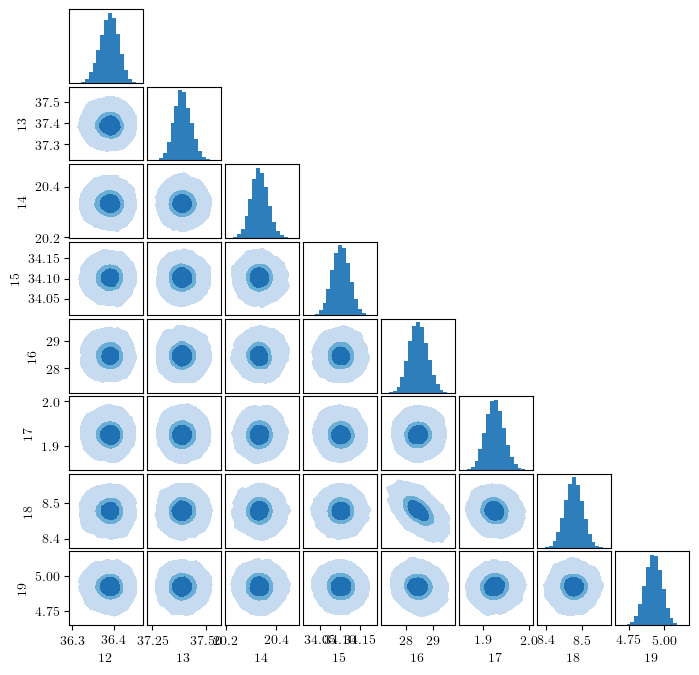

In [14]:
dims = 12:19
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [15]:
dims = 20:27
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 23×563646 Matrix{Float64} at index [24, 1:563646]

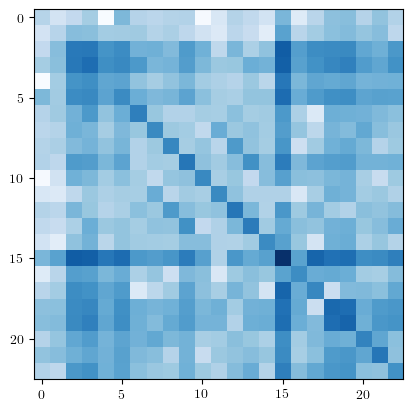

PyObject <matplotlib.image.AxesImage object at 0x7f38b798e430>

In [16]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

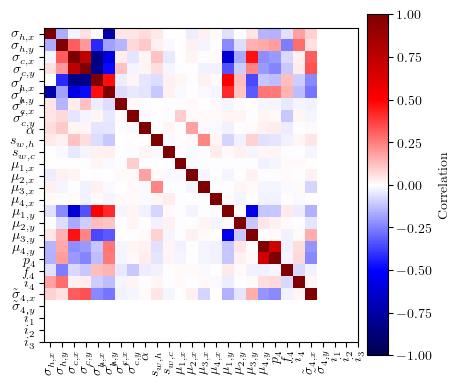

27-element Vector{PyCall.PyObject}:
 PyObject Text(0, 0, '$\\sigma_{h,x}$')
 PyObject Text(1, 0, '$\\sigma_{h,y}$')
 PyObject Text(2, 0, '$\\sigma_{c,x}$')
 PyObject Text(3, 0, '$\\sigma_{c,y}$')
 PyObject Text(4, 0, "$\\sigma'_{h,x}$")
 PyObject Text(5, 0, "$\\sigma'_{h,y}$")
 PyObject Text(6, 0, "$\\sigma'_{c,x}$")
 PyObject Text(7, 0, "$\\sigma'_{c,y}$")
 PyObject Text(8, 0, '$\\alpha$')
 PyObject Text(9, 0, '$s_{w,h}$')
 PyObject Text(10, 0, '$s_{w,c}$')
 PyObject Text(11, 0, '$\\mu_{1,x}$')
 PyObject Text(12, 0, '$\\mu_{2,x}$')
 ⋮
 PyObject Text(15, 0, '$\\mu_{1,y}$')
 PyObject Text(16, 0, '$\\mu_{2,y}$')
 PyObject Text(17, 0, '$\\mu_{3,y}$')
 PyObject Text(18, 0, '$\\mu_{4,y}$')
 PyObject Text(19, 0, '$p_4$')
 PyObject Text(20, 0, '$f_4$')
 PyObject Text(21, 0, '$i_4$')
 PyObject Text(22, 0, '$\\tilde{\\sigma}_{4,x}$')
 PyObject Text(23, 0, '$\\tilde{\\sigma}_{4,y}$')
 PyObject Text(24, 0, '$i_1$')
 PyObject Text(25, 0, '$i_2$')
 PyObject Text(26, 0, '$i_3$')

In [17]:
# SMALL_SIZE = 9
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 10

# # plt.rc("font", family="serif",) #serif="Times"
# # plt.rc("font", family= "Times New Roman")
# plt.rc("font", family="serif", serif="Computer Modern")
# plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
# plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc("text", usetex=true)

dt_reg = flatview(unshaped.(samples.v))
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = dt_reg ./ std(dt_reg, dims=2)

dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

figsize = (4.429223744292238, 4.429223744292238)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[15,1]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

maxval = maximum(abs.(dt_reg))
cb = ax1.imshow(dt_reg,  origin="upper", cmap="seismic", vmin=-maxval, vmax=maxval, aspect="equal") 
fig.colorbar(cb, spacing="proportional", label="Correlation", cax=ax2)

ax1.set_yticks(0:size(labels, 1)-1)
ax1.set_yticklabels(labels)

ax1.set_xticks(0:size(labels, 1)-1)
ax1.set_xticklabels(labels, rotation = 90)

# fig.savefig("../../plots/cor-event.pdf", bbox_inches = "tight")

In [18]:
if fname[1:2] == "hc"
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = parse(Int64, fname[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
    
    images = load("../../data/experiment/dataset_2/m2/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
end

(cam_1 = [0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.0; … ; 6.0 132.0 … 0.0 13.0; 216.0 0.0 … 0.0 0.0], cam_2 = [0.0 0.0 … 212.0 20.0; 0.0 0.0 … 0.0 0.0; … ; 12.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], cam_3 = [34.0 70.0 … 119.0 9.0; 0.0 310.0 … 229.0 4.0; … ; 104.0 21.0 … 0.0 0.0; 4.0 11.0 … 5.0 0.0], cam_4 = [23.0 53.0 … 23.0 26.0; 18.0 50.0 … 23.0 18.0; … ; 15.0 16.0 … 24.0 15.0; 17.0 15.0 … 20.0 14.0], population = 25.70319938659668)

In [19]:
if fname[1:2] == "lc"
    @show "true"
    conv_mat = load("../../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
    event_number = parse(Int64, fname[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    )
    
    images = load("../../data/experiment/dataset_2/m1/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

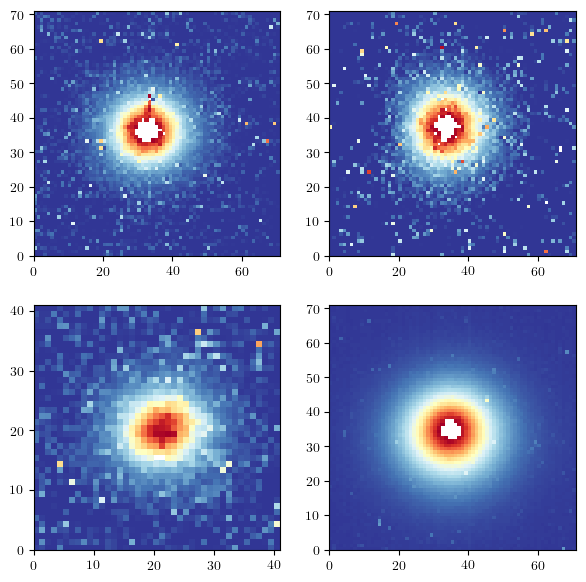

PyObject <matplotlib.collections.QuadMesh object at 0x7f38bda82550>

In [20]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

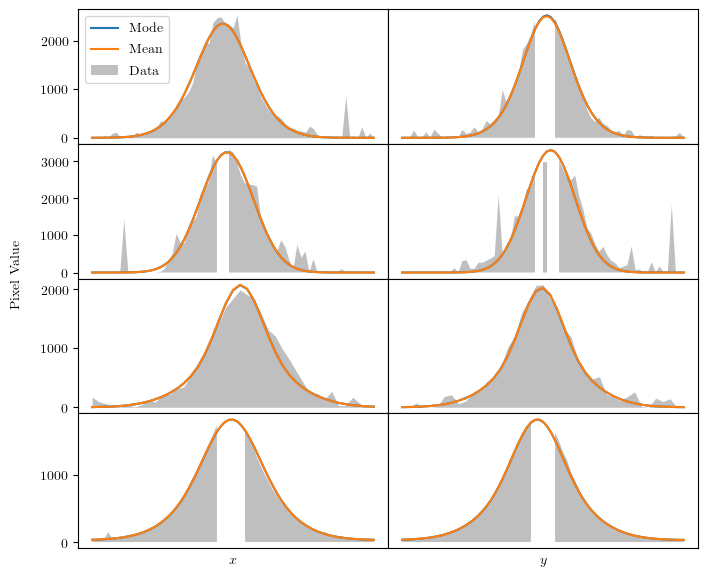

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


PyObject Text(0.04, 0.5, 'Pixel Value')

In [21]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

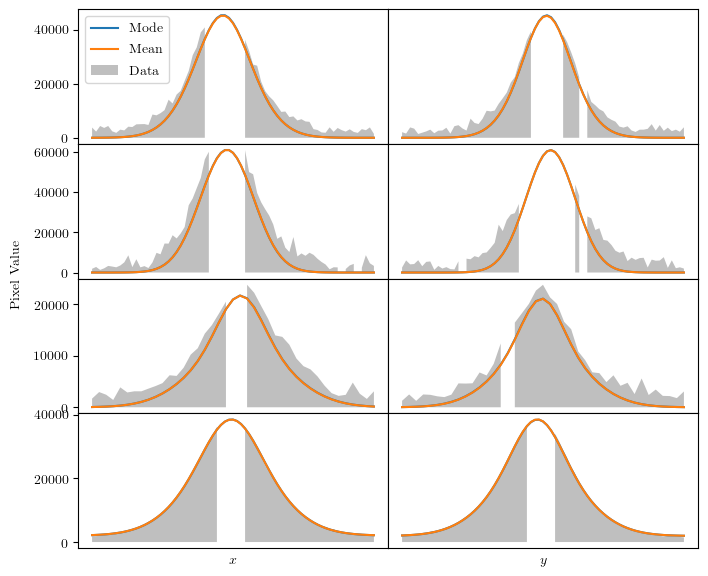

PyObject Text(0.04, 0.5, 'Pixel Value')

In [22]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

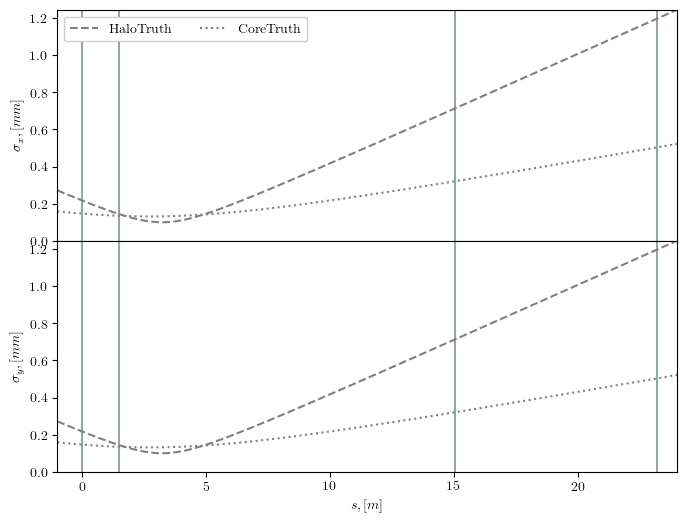

PyObject Text(0.5, 23.83700013837, '$s, [m]$')

In [23]:
params_array = [mode(samples)[1],]
colors_array = ["gray",]
labels_array = ["Truth", ]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [24]:
# plot_projections(conv_matrices, event_nt, event_nt, params_array[1], isnontr = true)

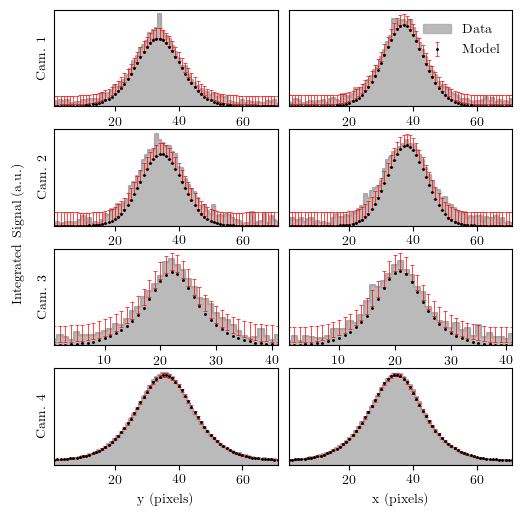

In [25]:
plot_projections(conv_matrices, event_nt, event_nt, params_array[1], 
    isnontr = true, 
    figsize=(5.905631659056317, 5.905631659056317),
    saveplot = false,
    filename = "../../plots/proj-m2-1.pdf"
)

In [26]:
plot_signal_envelope(params_array[1])

LoadError: BoundsError: attempt to access 1-element Vector{Float64} at index [2]